In [2]:
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import os
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchnet import meter

In [ ]:
label_mapping =  { 
     'zero':0,
     'one':1,
     'two':2,
     'three':3,
     'four':4,
     'five':5,
     'six':6,
     'seven':7,
     'eight':8,
     'nine':9,
     "plus":10,
     'sub':11,
     'mul':12,
     'div':13,
     '(':14,
     ')':15,
     }

In [8]:
class Mydataset(Dataset):
    def __init__(self,dir,transform=None):
        # 1. Initialize file path or list of file names.
        with np.load(dir) as data:
            self.img = data['img']
            self.label = data['label'].astype("int").tolist()
        self.__len = len(self.img)
        self.transform = transform
    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        #这里需要注意的是，第一步：read one data，是一个data point
        assert isinstance(index,int) and index >=0 and index <= self.__len
        if self.transform:
            img = self.transform(self.img[index])
        else:
            img = self.img[index]
        return (img,self.label[index])
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return self.__len

train_transform = transforms.Compose([
    lambda x: x/255,
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])
test_transform = transforms.Compose([
    lambda x: x/255,
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])

"""
工具
"""
from torchvision.utils import make_grid
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0][:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=32):
    """显示图片
    """
    for images in dl:
        show_images(images, nmax)
        break
class CNN(nn.Module):
    """一个mnist的CNN网络
    source : https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py
    """
    def __init__(self, num_classes=16):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
def train(epoch):  
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)  
        optimizer.zero_grad()  
        output = model(data)  
        ff = nn.CrossEntropyLoss()
        loss = criterion(output, target)  
        loss.backward()  
        optimizer.step()  
        if batch_idx % 20 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
def test():
    model.eval()  
    test_loss = 0  
    correct = 0 
    confusion_matrix = meter.ConfusionMeter(16)
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss 把所有loss值进行累加
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()  # 对预测正确的数据个数进行累加
        confusion_matrix.add(output.data, target.data)
    cm_value = confusion_matrix.value()
    accuracy = 100. * ( sum([cm_value[i][i] for i in range(16)])) / (cm_value.sum())
    test_loss /= len(test_loader.dataset)  # 因为把所有loss值进行过累加，所以最后要除以总得数据长度才得平均loss
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print("confusion_matrix",accuracy,"sum:",cm_value.sum())
    torch.cuda.empty_cache()
    return test_loss
def eval():
    model.eval()  
    test_loss = 0  
    correct = 0  
    confusion_matrix = meter.ConfusionMeter(16)
    for data, target in eval_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() 
        pred = output.data.max(1, keepdim=True)[1]  
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()  
        confusion_matrix.add(output.data, target.data)
    cm_value = confusion_matrix.value()
    print(cm_value)
    accuracy = 100. * (sum([cm_value[i][i] for i in range(16)])) / (cm_value.sum())
    test_loss /= len(eval_loader.dataset)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(eval_loader.dataset),
        100. * correct / len(eval_loader.dataset)))
    print("confusion_matrix",accuracy,"sum:",cm_value.sum())
    torch.cuda.empty_cache()
    return test_loss
def reload():
	train_size = int(0.8 * len(dataset))
	test_size = len(dataset) - train_size
	train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
	train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
											batch_size=128, 
											shuffle=True)
	test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
											batch_size=128, 
											shuffle=True)
	return train_loader,test_loader

In [9]:
dataset = Mydataset("extend_mnist_train.npz",train_transform)
eval_loader = torch.utils.data.DataLoader(dataset=Mydataset("extend_mnist_eval.npz",test_transform),
                                           batch_size=128, 
                                           shuffle=True)

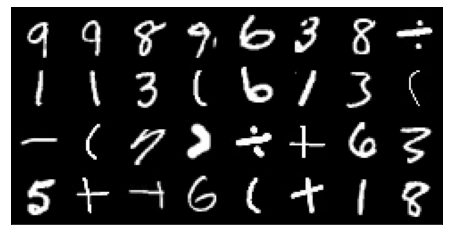

In [10]:
train_loader,_ = reload()
show_batch(train_loader)# 外部的数据不太清晰

In [11]:
import torchvision
model = CNN()
criterion=nn.CrossEntropyLoss()
model = model.cuda()
optimizer=optim.Adam(model.parameters(),lr=0.005)

In [12]:
test_losses = []
eval_losses = []
i = 1

In [13]:
%matplotlib inline
epochs = 20
for i in range(i,i+epochs):
	train_loader,test_loader = reload()
	train(i)
	t = test()
	test_losses.append(t)
	t = eval()
	eval_losses.append(t)

Train Epoch: 1 [0/71047 (0%)]	Loss: 2.842498
Train Epoch: 1 [2560/71047 (4%)]	Loss: 0.456265
Train Epoch: 1 [5120/71047 (7%)]	Loss: 0.299295
Train Epoch: 1 [7680/71047 (11%)]	Loss: 0.201493
Train Epoch: 1 [10240/71047 (14%)]	Loss: 0.083606
Train Epoch: 1 [12800/71047 (18%)]	Loss: 0.148382
Train Epoch: 1 [15360/71047 (22%)]	Loss: 0.078371
Train Epoch: 1 [17920/71047 (25%)]	Loss: 0.123629
Train Epoch: 1 [20480/71047 (29%)]	Loss: 0.076353
Train Epoch: 1 [23040/71047 (32%)]	Loss: 0.203478
Train Epoch: 1 [25600/71047 (36%)]	Loss: 0.233259
Train Epoch: 1 [28160/71047 (40%)]	Loss: 0.156816
Train Epoch: 1 [30720/71047 (43%)]	Loss: 0.201029
Train Epoch: 1 [33280/71047 (47%)]	Loss: 0.165410
Train Epoch: 1 [35840/71047 (50%)]	Loss: 0.089985
Train Epoch: 1 [38400/71047 (54%)]	Loss: 0.090285
Train Epoch: 1 [40960/71047 (58%)]	Loss: 0.087649
Train Epoch: 1 [43520/71047 (61%)]	Loss: 0.051744
Train Epoch: 1 [46080/71047 (65%)]	Loss: 0.077692
Train Epoch: 1 [48640/71047 (68%)]	Loss: 0.028776
Train Epoc

D:\pyenv\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: -14.8307, Accuracy: 17411/17762 (98%)

confusion_matrix 98.0238711856773 sum: 17762
[[ 975    0    0    0    0    0    2    1    2    0    0    0    0    0
     0    0]
 [   0 1130    1    0    0    0    1    1    0    0    0    0    0    0
     1    1]
 [  11    6 1004    0    3    0    0    6    0    0    0    0    0    0
     1    1]
 [   3    0    1  980    0   12    0    8    3    0    0    0    0    0
     0    3]
 [   0    0    0    0  980    0    1    0    0    0    1    0    0    0
     0    0]
 [   2    0    0    1    0  883    3    1    0    2    0    0    0    0
     0    0]
 [   5    2    0    0    1    4  946    0    0    0    0    0    0    0
     0    0]
 [   1    2    7    0    1    0    0 1014    1    2    0    0    0    0
     0    0]
 [  16    0    4    0    8    3    4    4  932    3    0    0    0    0
     0    0]
 [   7    5    0    0   25   10    0   16    2  944    0    0    0    0
     0    0]
 [   0    0    0    0    8    2    0    0

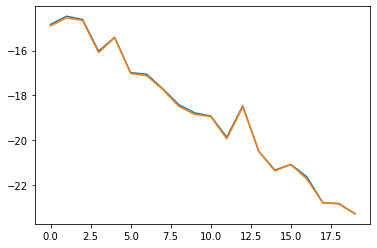

In [14]:
plt.cla()
plt.plot(list(range(len(test_losses))),test_losses)
plt.plot(list(range(len(eval_losses))),eval_losses)

In [15]:
np.array(test_losses) - np.array(eval_losses)

array([ 0.0729649 ,  0.07167068,  0.04409703,  0.06230195,  0.01338762,
        0.03720948,  0.07091322,  0.03182394,  0.07481772,  0.06782775,
        0.0229346 ,  0.07596549,  0.0481766 , -0.00847702,  0.03294252,
        0.00846792,  0.09881705,  0.00655675,  0.02419121,  0.01008271])

In [16]:
dummy_input = torch.randn(1, 1, 28, 28, device='cuda')

In [17]:
torch.onnx.export(model, dummy_input, "mynet.onnx", verbose=True, input_names=["input"])

graph(%input : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(16, 1568, strides=[1568, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(16, strides=[1], requires_grad=1, device=cuda:0),
      %33 : Float(16, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=0, device=cuda:0),
      %34 : Float(16, strides=[1], requires_grad=0, device=cuda:0),
      %36 : Float(32, 16, 5, 5, strides=[400, 25, 5, 1], requires_grad=0, device=cuda:0),
      %37 : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %40 : Long(2, strides=[1], requires_grad=0, device=cpu)):
  %32 : Float(1, 16, 28, 28, strides=[12544, 784, 28, 1], requires_grad=1, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input, %33, %34)
  %19 : Float(1, 16, 28, 28, strides=[12544, 784, 28, 1], requires_grad=1, device=cuda:0) = onnx::Relu(%32) # D:\pyenv\torch\lib\site-packages\torch\nn\functional.